## Library

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

## Training Date Load

In [2]:
train = pd.read_csv('./train/train.csv')
target = 'target'   # 2번째 컬럼
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [3]:
np.sum(train['target'] == 1), np.sum(train['target'] == 0)

(16078, 143922)

In [4]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set', 'ID_code']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]



X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

ID_code 160000
target 2
Set 3


In [5]:
X_train.shape

(128036, 200)

In [6]:
train.dtypes

ID_code      int32
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Set          int32
Length: 203, dtype: object

## Custom Loss Function

In [14]:
from sklearn.utils import class_weight
class_weights= class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array(y_train))
class_weights= torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

tensor([0.5558, 4.9792])


In [15]:
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

## Custom Eval Metrics

### F1 Score

In [16]:
from sklearn.metrics import f1_score

y_true = np.array([1, 1, 1, 0, 1, 0])
y_pred = np.array([0, 1, 1, 0, 0, 1])
precision = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
print(f1_score(y_true, y_pred, average='binary'), precision, recall)

f1_sc = 2 * (precision * recall) / (precision + recall)
print(f1_sc)

0.5714285714285715 0.6666666666666666 0.5
0.5714285714285715


In [17]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score

class F1score(Metric):
    def __init__(self):
        self._name = "f1score"
        self._maximize = True

    def __call__(self, y_true, y_score):

        return f1_score(y_true, (y_score[:, 1]>0.5)*1, average = 'binary')

In [18]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # "sparsemax", entmax
                      )

C:\Users\eric0\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [19]:
max_epochs = 100

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[F1score],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    loss_fn = criterion,
    drop_last=False,
)

epoch 0  | loss: 0.34121 | train_f1score: 0.18223 | valid_f1score: 0.1887  |  0:00:20s
epoch 1  | loss: 0.32497 | train_f1score: 0.18251 | valid_f1score: 0.18904 |  0:00:42s
epoch 2  | loss: 0.32109 | train_f1score: 0.18251 | valid_f1score: 0.18904 |  0:01:04s
epoch 3  | loss: 0.31714 | train_f1score: 0.18251 | valid_f1score: 0.18904 |  0:01:24s
epoch 4  | loss: 0.31336 | train_f1score: 0.18273 | valid_f1score: 0.18899 |  0:01:45s
epoch 5  | loss: 0.29022 | train_f1score: 0.20498 | valid_f1score: 0.20961 |  0:02:05s
epoch 6  | loss: 0.25947 | train_f1score: 0.22277 | valid_f1score: 0.22733 |  0:02:25s
epoch 7  | loss: 0.24349 | train_f1score: 0.23798 | valid_f1score: 0.24193 |  0:02:47s
epoch 8  | loss: 0.23791 | train_f1score: 0.22189 | valid_f1score: 0.2274  |  0:03:07s
epoch 9  | loss: 0.23161 | train_f1score: 0.23291 | valid_f1score: 0.23721 |  0:03:27s
epoch 10 | loss: 0.2273  | train_f1score: 0.26119 | valid_f1score: 0.26169 |  0:03:47s
epoch 11 | loss: 0.22057 | train_f1score: 0

epoch 95 | loss: 0.12845 | train_f1score: 0.41031 | valid_f1score: 0.33803 |  0:32:22s
epoch 96 | loss: 0.12966 | train_f1score: 0.38209 | valid_f1score: 0.3262  |  0:32:41s
epoch 97 | loss: 0.12939 | train_f1score: 0.44114 | valid_f1score: 0.35653 |  0:33:01s
epoch 98 | loss: 0.1306  | train_f1score: 0.44641 | valid_f1score: 0.35665 |  0:33:21s
epoch 99 | loss: 0.12892 | train_f1score: 0.44807 | valid_f1score: 0.35559 |  0:33:40s
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_f1score = 0.35787


C:\Users\eric0\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [20]:
preds = clf.predict_proba(X_test)
test_f1score = f1_score(y_true = y_test, y_pred = (preds[:, 1]>0.5)*1, average = 'binary')
test_f1score

0.3360517435320585

In [21]:
y_pred = (preds[:, 1]>0.5)*1
acc = (np.sum((y_pred == 1) & (y_test == 1)) + np.sum((y_pred == 0) & (y_test == 0))) / len(y_pred)
precision = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
print(precision, recall, acc)

0.21488940837978782 0.7704706640876854 0.7042465238632093


## Feature Extract

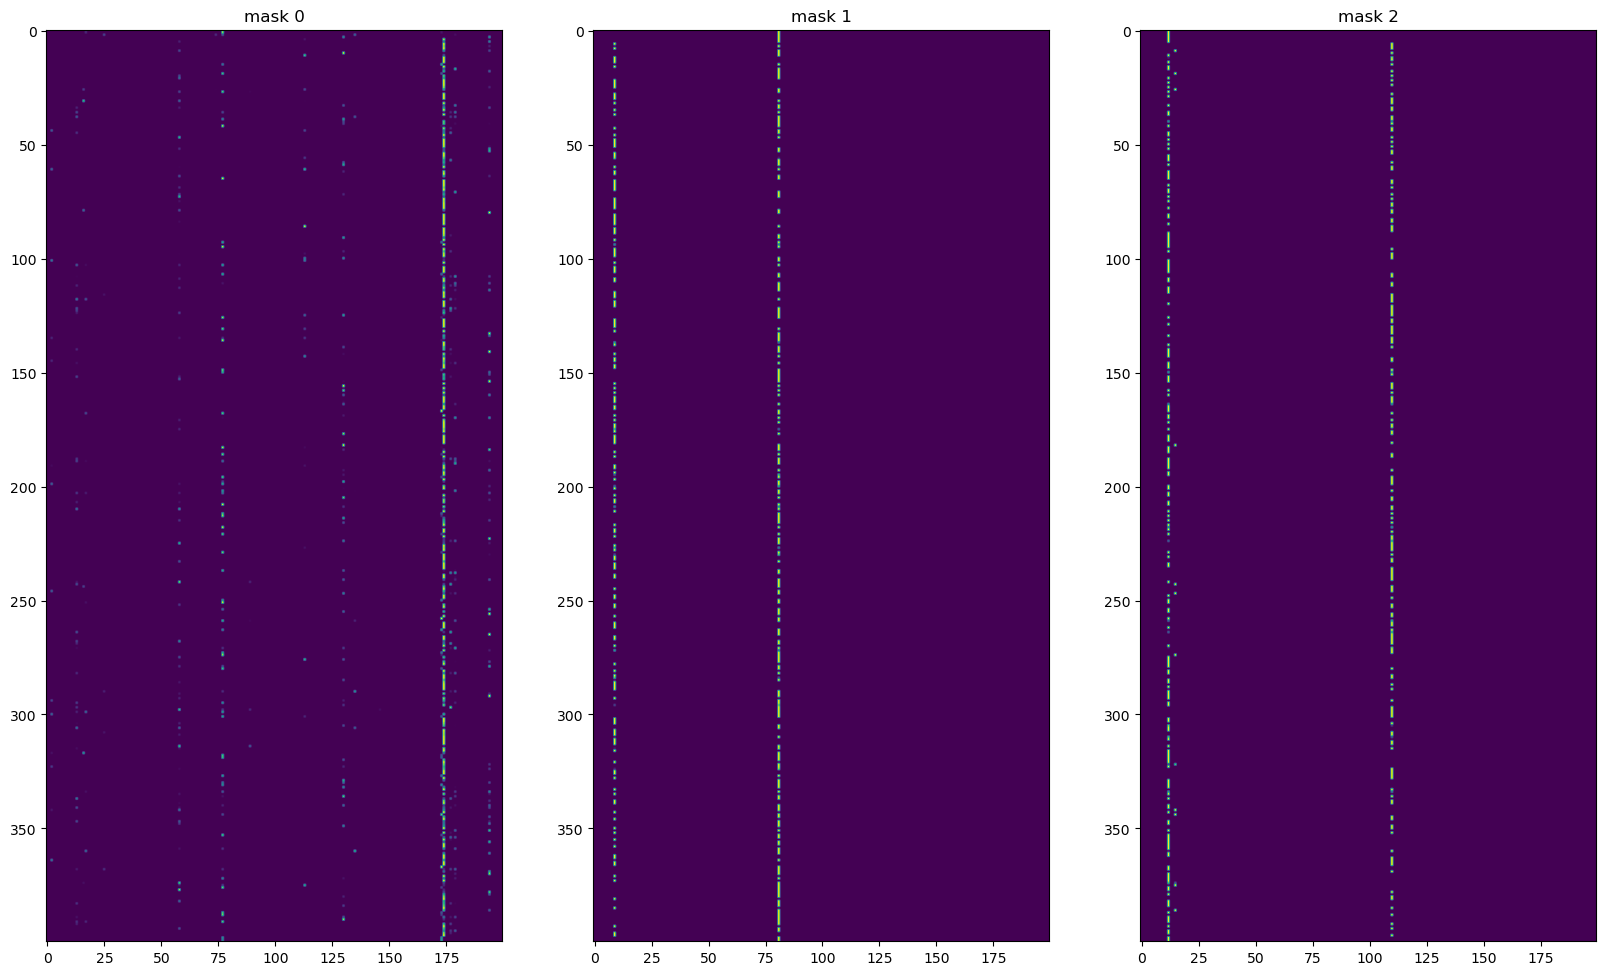

In [22]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:400])
    axs[i].set_title(f"mask {i}")

In [20]:
masks[1][3]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
explain_vector = explain_matrix.mean(axis=0)
explain_vector.argsort()

array([ 99,  41,  42, 152, 145,  51, 144, 141,  57,  59, 139,  61, 138,
        63,  64,  65, 137, 134, 110,  95, 112, 114, 115, 116, 154, 118,
        80,  77, 120,  74,  71, 133,  82, 159, 104,  22, 170, 169, 187,
       181,   7,   4, 184,  26,  30, 165, 164,  18,  19, 178, 197, 194,
        44, 185,  84,  39,  38, 196, 172, 179,  52, 182, 135,  46,  73,
        79,  25, 160, 193,  43, 198, 177,  78, 161, 158,  45,  96,   9,
       143, 190, 140,   6, 101, 150, 107, 100, 129,  86,  68, 167,   8,
       156, 113,  97, 171, 142,  98, 186,  90,  87, 119,  88,  48, 132,
        83, 199,  56, 126,  89, 131, 149,  50,  27, 136, 108,  67,  60,
       117,  21,   0,  36, 163, 166,  70,  72, 183, 176, 102,  92,  24,
        29,  32,  16, 162,  40,  62,  94, 130,  47, 146,  33,  23, 103,
       175,  75,  10, 106,  14,  58,  54, 122,  31,  69,   1,  37,   5,
       157, 105, 173, 127, 195,  35, 189,   3, 155, 180,  93,  17,  28,
       125, 124,  85,  11,  55, 123,  12, 168, 191, 109, 121, 12

In [21]:
import seaborn as sns 
plt.plot(explain_vector)

NameError: name 'explain_vector' is not defined

In [23]:
test = pd.read_csv('./test/test.csv')
test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_1,8.7757,6.7905,9.2920,4.8443,10.8877,3.5858,4.7267,14.1264,1.9131,...,4.8996,4.4960,2.0201,5.0578,18.7864,-0.2550,4.0958,7.9291,17.6055,-7.4019
1,test_2,7.5491,-8.4764,15.4626,3.6803,12.1527,-7.1858,5.1952,13.7568,2.5632,...,10.2822,11.9053,3.0869,-0.6879,22.3453,-2.1595,4.1147,9.2685,12.2069,1.3086
2,test_3,5.8385,-6.9177,8.1589,6.7591,9.0635,4.9003,4.7126,21.1854,-3.5385,...,0.0732,10.2627,-0.3105,6.8481,15.2119,-0.5050,1.8873,8.6977,18.6569,11.5001
3,test_4,15.6901,-7.7904,8.3676,6.3246,9.8144,6.9361,4.5284,11.7888,3.3775,...,11.8331,4.3828,2.9730,2.4989,18.6336,1.0621,-3.8953,8.7950,12.9313,-3.1393
4,test_5,15.5726,-6.6387,12.0251,7.2093,10.3838,-8.9961,4.8868,18.8259,-5.2734,...,7.9042,10.4118,3.3438,0.4358,16.0511,0.7758,-3.3334,7.7918,18.2619,-3.2074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,test_39996,13.9605,1.6317,16.5365,5.5922,12.2347,-14.3060,5.0389,18.4215,4.0158,...,-1.3783,8.9957,2.2425,9.3388,14.8871,0.8290,-1.0208,8.3668,16.5769,2.4484
39996,test_39997,7.4985,4.7339,11.9952,6.2574,9.8171,4.6362,4.6372,13.3072,-0.5075,...,5.5200,9.0240,2.1368,4.9087,16.1938,0.5539,6.7445,10.1029,20.6326,-19.7800
39997,test_39998,4.5195,3.8886,7.4813,8.1466,11.8629,-4.4444,5.1001,23.0027,-3.2955,...,7.0380,3.5980,1.9735,3.4259,15.9605,1.0190,3.0311,6.7328,15.8304,-2.2132
39998,test_39999,8.8422,3.3068,8.3702,9.4941,11.5611,13.2109,5.3921,11.9120,-2.1810,...,7.4395,10.4932,3.7310,11.7952,17.9021,-1.4007,-6.2355,9.4922,14.9396,-9.6255


In [24]:
nunique = test.nunique()
types = test.dtypes

categorical_columns = []
categorical_dims =  {}
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[:, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set', 'ID_code']
features = [ col for col in test.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

test[features]

ID_code 40000


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.7757,6.7905,9.2920,4.8443,10.8877,3.5858,4.7267,14.1264,1.9131,7.1682,...,4.8996,4.4960,2.0201,5.0578,18.7864,-0.2550,4.0958,7.9291,17.6055,-7.4019
1,7.5491,-8.4764,15.4626,3.6803,12.1527,-7.1858,5.1952,13.7568,2.5632,8.1126,...,10.2822,11.9053,3.0869,-0.6879,22.3453,-2.1595,4.1147,9.2685,12.2069,1.3086
2,5.8385,-6.9177,8.1589,6.7591,9.0635,4.9003,4.7126,21.1854,-3.5385,8.3261,...,0.0732,10.2627,-0.3105,6.8481,15.2119,-0.5050,1.8873,8.6977,18.6569,11.5001
3,15.6901,-7.7904,8.3676,6.3246,9.8144,6.9361,4.5284,11.7888,3.3775,8.8897,...,11.8331,4.3828,2.9730,2.4989,18.6336,1.0621,-3.8953,8.7950,12.9313,-3.1393
4,15.5726,-6.6387,12.0251,7.2093,10.3838,-8.9961,4.8868,18.8259,-5.2734,7.3476,...,7.9042,10.4118,3.3438,0.4358,16.0511,0.7758,-3.3334,7.7918,18.2619,-3.2074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,13.9605,1.6317,16.5365,5.5922,12.2347,-14.3060,5.0389,18.4215,4.0158,7.0972,...,-1.3783,8.9957,2.2425,9.3388,14.8871,0.8290,-1.0208,8.3668,16.5769,2.4484
39996,7.4985,4.7339,11.9952,6.2574,9.8171,4.6362,4.6372,13.3072,-0.5075,8.3850,...,5.5200,9.0240,2.1368,4.9087,16.1938,0.5539,6.7445,10.1029,20.6326,-19.7800
39997,4.5195,3.8886,7.4813,8.1466,11.8629,-4.4444,5.1001,23.0027,-3.2955,6.2351,...,7.0380,3.5980,1.9735,3.4259,15.9605,1.0190,3.0311,6.7328,15.8304,-2.2132
39998,8.8422,3.3068,8.3702,9.4941,11.5611,13.2109,5.3921,11.9120,-2.1810,5.9458,...,7.4395,10.4932,3.7310,11.7952,17.9021,-1.4007,-6.2355,9.4922,14.9396,-9.6255


In [25]:
R_test = test[features].values
R_test.shape

(40000, 200)

In [26]:
preds = clf.predict_proba(R_test)
np.where(preds[:] < 0.5)

(array([    0,     1,     2, ..., 39997, 39998, 39999], dtype=int64),
 array([1, 1, 1, ..., 1, 0, 1], dtype=int64))

In [27]:
y_pred = np.where(preds[:] > 0.5)[1]

In [28]:
test1 = pd.read_csv('./test/test.csv')
submission = pd.DataFrame({"ID_code": test1['ID_code'].values, "target": y_pred})
submission.to_csv('submission_Tabnet_2.csv', index = False)